In [151]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [153]:
train=
test=
val=

In [155]:
img_size=(380,380)
batch_size=32

In [157]:
#image data augmentation fro training set (helps prevent overfitting)
train_datagen=ImageDataGenerator (
    rescale=1./255,#normalize pixel values
    rotation_range=20,#ratote image by 20%
    width_shift_range=0.2,#vertical shifting
    height_shift_range=0.2,#horizontal shifting
    zoom_range=0.2,# Randomly zoom images
    horizontal_flip=True, # Flip images horizontally
    fill_mode='nearest'   # Fill missing pixels after transformation
)

In [159]:
#only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

In [161]:
#loading data
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'  # S pneumonia /Normal
)

val_generator = val_datagen.flow_from_directory(
    val,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 2769 images belonging to 2 classes.
Found 438 images belonging to 2 classes.


In [163]:
#loading EfficientNetB4
base_model = EfficientNetB4(weights="imagenet", include_top=False, input_shape=(380, 380, 3))

# Freeze the Base Model
base_model.trainable = False

In [165]:
# performing binary classification (Pneumonia / Normal),
#we need to add a new classification head on top of EfficientNet.
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(0.5)(x)
x=Dense(128,activation='relu')(x)#fully connected layer with 128 meurons
x=Dropout(0.3)(x)
output=Dense(1,activation='sigmoid')(x)
model=Model(inputs=base_model.input,outputs=output)

In [167]:
#fine-tuning, we train the top classification layers while keeping EfficientNet frozen.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [171]:
history=model.fit(train_generator,
                 validation_data=val_generator,
                 epochs=15,
                 steps_per_epoch=len(train_generator),#Automatically adjusts based on dataset size. Ensures the model processes all images in one epoch.Prevents missing data or incomplete training.
                 validation_steps=len(val_generator))

Epoch 1/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 386s 4s/step - accuracy: 0.5046 - loss: 0.7010 - val_accuracy: 0.5023 - val_loss: 0.6942
Epoch 2/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 385s 4s/step - accuracy: 0.4866 - loss: 0.6973 - val_accuracy: 0.5023 - val_loss: 0.6932
Epoch 3/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 387s 4s/step - accuracy: 0.5178 - loss: 0.6969 - val_accuracy: 0.4977 - val_loss: 0.6926
Epoch 4/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 1409s 16s/step - accuracy: 0.5103 - loss: 0.6938 - val_accuracy: 0.4977 - val_loss: 0.6931
Epoch 5/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 385s 4s/step - accuracy: 0.4983 - loss: 0.6963 - val_accuracy: 0.5023 - val_loss: 0.6956
Epoch 6/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 388s 4s/step - accuracy: 0.5076 - loss: 0.6947 - val_accuracy: 0.5023 - val_loss: 0.6927
Epoch 7/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 398s 5s/step - accuracy: 0.5023 - loss: 0.6943 - val_accuracy: 0.5023 - val_loss: 0.6931
Epoch 8/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 387s 4s/step - accuracy: 0.4941 - loss: 0.6955 - val_accuracy: 0.5023 -

In [179]:
# Unfreeze the Last 50 Layers for Fine-Tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

In [181]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Lower LR for fine-tuning
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [183]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

In [185]:
history_finetuning = model.fit(train_generator,
                         validation_data=val_generator,
                         epochs=30,
                         callbacks=[early_stopping],
                         steps_per_epoch=len(train_generator),
                         validation_steps=len(val_generator))

Epoch 1/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 506s 5s/step - accuracy: 0.5183 - loss: 0.7118 - val_accuracy: 0.5023 - val_loss: 0.6926
Epoch 2/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 440s 5s/step - accuracy: 0.5004 - loss: 0.7024 - val_accuracy: 0.5023 - val_loss: 0.6922
Epoch 3/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 439s 5s/step - accuracy: 0.5140 - loss: 0.7024 - val_accuracy: 0.5023 - val_loss: 0.6916
Epoch 4/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 439s 5s/step - accuracy: 0.5225 - loss: 0.6962 - val_accuracy: 0.5023 - val_loss: 0.6911
Epoch 5/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 439s 5s/step - accuracy: 0.5197 - loss: 0.6942 - val_accuracy: 0.5023 - val_loss: 0.6894
Epoch 6/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 440s 5s/step - accuracy: 0.5305 - loss: 0.6911 - val_accuracy: 0.5068 - val_loss: 0.6909
Epoch 7/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 443s 5s/step - accuracy: 0.5286 - loss: 0.6957 - val_accuracy: 0.5046 - val_loss: 0.6893
Epoch 8/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 439s 5s/step - accuracy: 0.5126 - loss: 0.6938 - val_accuracy: 0.5046 - v

In [187]:
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 380, 380, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_2 (Rescaling)       │ (None, 380, 380, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_1               │ (None, 380, 380, 3)       │               7 │ rescaling_2[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_3 (Rescaling)       │ (None, 380, 380, 3)       │               0 │ normalization_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 381, 381, 3)       │               0 │ rescaling_3[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 190, 190, 48)      │           1,296 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 190, 190, 48)      │             192 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 190, 190, 48)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 190, 190, 48)      │             432 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 190, 190, 48)      │             192 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 190, 190, 48)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 48)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 48)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 12)          │             588 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 48)          │             62

 Total params: 32,123,092 (122.54 MB)

 Trainable params: 7,109,817 (27.12 MB)

 Non-trainable params: 10,793,639 (41.17 MB)

 Optimizer params: 14,219,636 (54.24 MB)

In [189]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [191]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images in batches
test_generator = test_datagen.flow_from_directory(
    test,
    target_size=(380, 380),  # Match EfficientNet input size
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

Found 499 images belonging to 2 classes.


In [193]:
# Get true labels
y_true = test_generator.classes

# Predict on test data
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert to binary labels


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step


In [194]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))

# Compute overall accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"🔍 Model Accuracy: {accuracy:.4f}")


Classification Report:
              precision    recall  f1-score   support

      Normal       0.79      0.36      0.50       234
   Pneumonia       0.62      0.92      0.74       265

    accuracy                           0.66       499
   macro avg       0.71      0.64      0.62       499
weighted avg       0.70      0.66      0.63       499

🔍 Model Accuracy: 0.6573


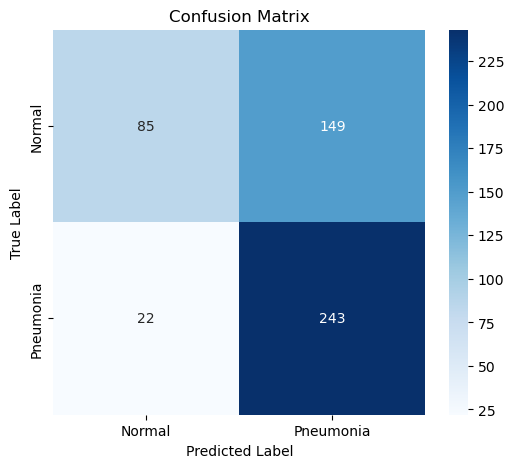

In [197]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Text(0.5, 1.0, 'Fine-Tuned Accuracy Curve')

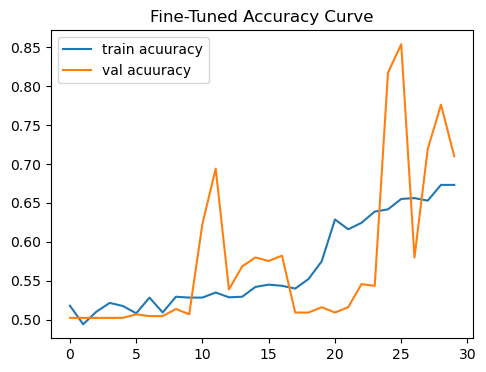

In [199]:
plt.figure(figsize=(12,4))
#accuracy plot
plt.subplot(1,2,1)
plt.plot(history_finetuning.history['accuracy'],label='train acuuracy')
plt.plot(history_finetuning.history['val_accuracy'],label='val acuuracy')
plt.legend()
plt.title('Fine-Tuned Accuracy Curve')

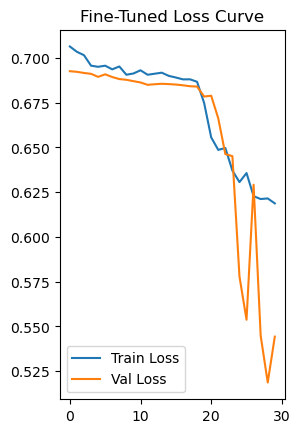

In [201]:
# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_finetuning.history['loss'], label='Train Loss')
plt.plot(history_finetuning.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Fine-Tuned Loss Curve')

plt.show()

In [203]:
model.save("fine_tuned_pneumonia_efficientnet.h5")


In [205]:
from tensorflow.keras.models import load_model

In [207]:
import numpy as np
import cv2 # OpenCV for image processing
from tensorflow.keras.applications.efficientnet import preprocess_input

In [209]:
model=tf.keras.models.load_model('fine_tuned_pneumonia_efficientnet.h5')

In [211]:
def load_preprocess(image_path,img_size=(380,380)):
    img=cv2.imread(image_path)
    
    if len(img.shape)==2:
        img=cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    img=cv2.resize(img,img_size)
    img=np.array(img,dtype=np.float32)
    img=preprocess_input(img)
    img=np.expand_dims(img,axis=0)
    return img

In [213]:
def grad_cam(model,img_array,layer_name="top_conv"):
    grad_model=tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output,model.output]
    )#gets the modela last convolutional layer

    
    with tf.GradientTape() as tape:
        conv_output,predictions=grad_model(img_array)
        pred_class=predictions[0][0]
        loss=pred_class

    grads=tape.gradient(loss,conv_output)
    pooled_grads=tf.reduce_mean(grads,axis=(0,1,2))

    conv_output=conv_output[0]
    heatmap=np.dot(conv_output,pooled_grads.numpy().reshape(-1,1)).squeeze()

    heatmap=np.maximum(heatmap,0)#(remove negative values)
    heatmap/-np.max(heatmap)# Normalize to 0-1 range
    return heatmap

In [215]:
def overlay_heatmap(img_path, heatmap, alpha=0.6):
    #Load the original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
     # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    #Convert heatmap to color
    heatmap = np.uint8(255 * heatmap)  # Scale 0-255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply color map
    #Blend heatmap with original image
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    #Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Original X-ray")
    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title("Grad-CAM Heatmap")
    plt.show()


In [217]:
def predict_pneumonia(image_path):
    """Predict whether an X-ray image shows pneumonia or not."""
    # Load and preprocess the image
    img = load_preprocess(image_path)
    
    # Get prediction (model outputs probability)
    prediction = model.predict(img)[0][0]
    
    # Set threshold (0.5 for binary classification)
    if prediction > 0.5:
        result = "Pneumonia Detected"
        confidence = prediction * 100
    else:
        result = "Normal"
        confidence = (1 - prediction) * 100

    # Show the image and prediction result
    plt.imshow(cv2.imread(image_path), cmap='gray')
    plt.axis('off')
    plt.title(f"Prediction: {result}\nConfidence: {confidence:.2f}%")
    plt.show()

    return result, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


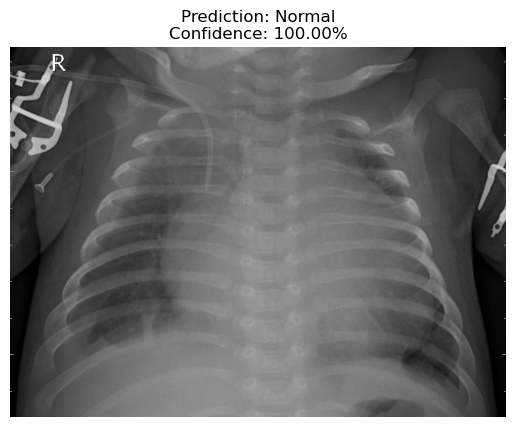

Result: Normal | Confidence: 100.00%


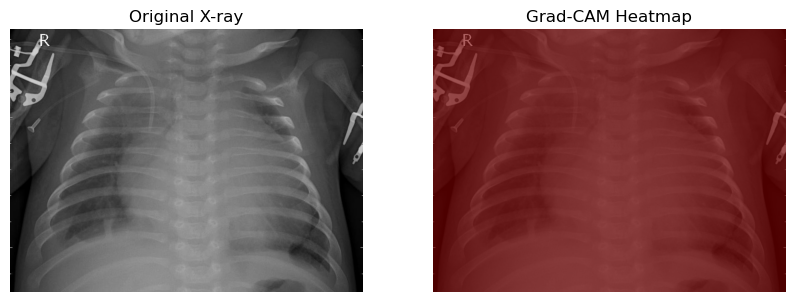

In [223]:
image_path=r"C:\Users\albin\OneDrive\Desktop\data science\DEEP LEARNING PROJECT\person141_bacteria_677.jpeg"
#Load and preprocess image
img_array = load_preprocess(image_path)
#Generate heatmap
heatmap = grad_cam(model, img_array, layer_name="top_conv")
#prediction
prediction, confidence = predict_pneumonia(image_path)
print(f"Result: {prediction} | Confidence: {confidence:.2f}%")
#Overlay heatmap on X-ray
overlay_heatmap(image_path, heatmap)
